In [20]:
import torchvision
import torchvision.transforms as transforms
import torch

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(
    root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=4)


In [21]:
import torch.nn as nn
import torch.nn.functional as F
class PlainBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels,
                               kernel_size=3, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels,
                               kernel_size=3, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

In [26]:
class PlainNet(nn.Module):
    def __init__(self, depth):
        super().__init__()
        n_blocks = (depth - 2) // 2
        self.conv = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn= nn.BatchNorm2d(16)
        
        self.blocks = nn.Sequential(
            *[PlainBlock(16) for _ in range(n_blocks)]
        )
        
        self.fc = nn.Linear(16, 10)
    
    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.blocks(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(x.size(0), -1)
        return self.fc(x)
        

In [27]:
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def train(model, epochs=200):
    model.to(device)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[100, 150], gamma=0.1
    )
    criterion = nn.CrossEntropyLoss()
    losses = []
    loop = tqdm(range(epochs))
    for epoch in loop:
        model.train()
        total_loss = 0.0
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        losses.append(total_loss)
        loop.set_description(f'Epoch {epoch + 1}: loss={total_loss:.2f}')
    
    return losses

In [ ]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [30]:
p20 = PlainNet(20)
p20.apply(init_weights)
p20_losses = train(p20)

Epoch 3: loss=532.62:   2%|▏         | 3/200 [01:22<1:29:26, 27.24s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002141FB04310>
Traceback (most recent call last):
  File "c:\Users\BRUH\miniconda3\envs\digit\lib\site-packages\torch\utils\data\dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "c:\Users\BRUH\miniconda3\envs\digit\lib\site-packages\torch\utils\data\dataloader.py", line 1612, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002141FB04310>
Traceback (most recent call last):
  File "c:\Users\BRUH\miniconda3\envs\digit\lib\site-packages\torch\utils\data\dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "c:\Users\BRUH\miniconda3\envs\digit\lib\site-packages\torch\utils\data\dataloader.py"

In [31]:
p50 = PlainNet(50)
p50.apply(init_weights)
p50_losses = train(p50)

Epoch 200: loss=104.40: 100%|██████████| 200/200 [2:14:09<00:00, 40.25s/it]  


In [34]:
import math
log_p20_losses = [math.log(p) for p in p20_losses]
log_p50_losses = [math.log(p) for p in p50_losses]

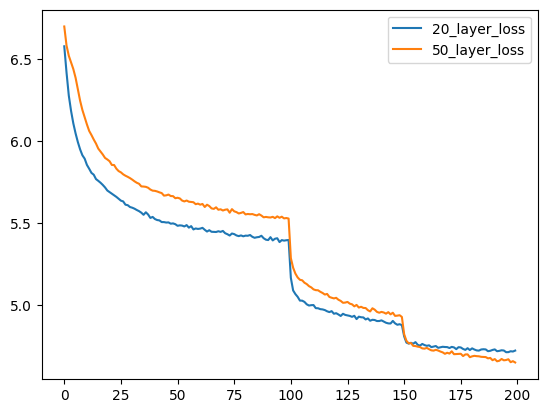

In [35]:
import matplotlib.pyplot as plt
xs = range(len(p50_losses))
plt.plot(xs, log_p20_losses, label='20_layer_loss')
plt.plot(xs, log_p50_losses, label='50_layer_loss')
plt.legend()
plt.show()


**Conclusion**: This result contradicts with degradation problem which says deeper model can't use its capacity (more parameters) to generalize, but it does in this case because it uses `Batch Normalization` with `Xavier Initialization`. But the graph still says that in order to use the capacity to generalize it still takes more time to generalize.